# Inference

In this notebook, we will use the trained model to generate captions for images in the test dataset.

## Get Data Loader for Test Dataset

In [ ]:
import sys
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                      
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test', cocoapi_loc= '/mnt/disks/legacy-jupytergpu-data/')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

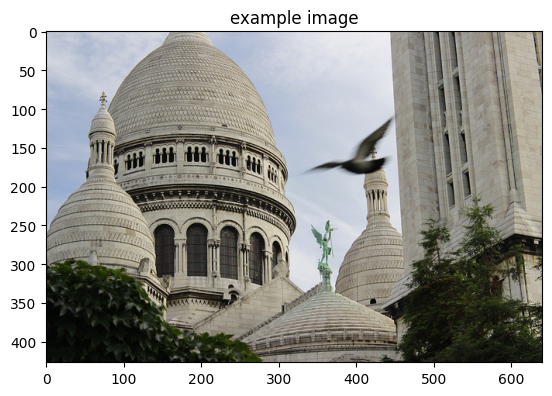

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

## Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import torch
from model import EncoderCNN, DecoderRNN

# Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# Specify the model parameters 
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DecoderRNN(
  (embed): Embedding(8852, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8852, bias=True)
  (hidden_init): Linear(in_features=256, out_features=512, bias=True)
)

### A note on the Sample Method

The `sample` method in the `DecoderRNN` class in **model.py**. This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

In [6]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 446, 562, 6, 3, 174, 2, 39, 32, 112, 18, 1]


## Clean up the Captions

The `clean_sentence` function.  It takes a list of integers (corresponding to the variable `output` as input and return the corresponding predicted sentence (as a single Python string).

In [ ]:
def clean_sentence(output):
    sentence_parts = []
    for idx in output:
        word = data_loader.dataset.vocab.idx2word[idx]
        if word == '<start>':
            continue
        if word == '<end>':
            break
        sentence_parts.append(word)
    return ' '.join(sentence_parts)

In [8]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a wood door and a bus <unk> on the table .


## Generate Predictions

The `get_prediction` function is used to loop over images in the test dataset and print the model's predicted caption.

In [9]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(output)
    print(sentence)

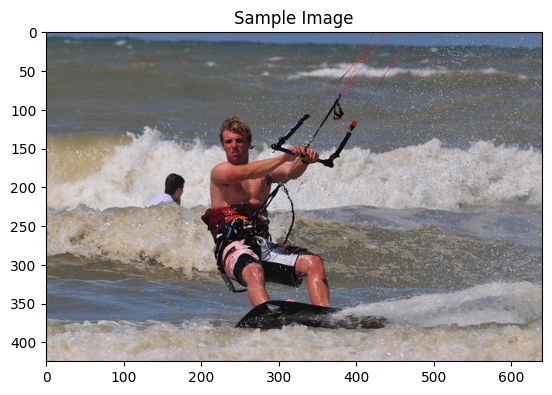

[0, 3, 169, 139, 3, 356, 77, 32, 392, 13, 3, 24, 18, 1]
a man riding a frisbee in the middle of a wall .


In [10]:
get_prediction()

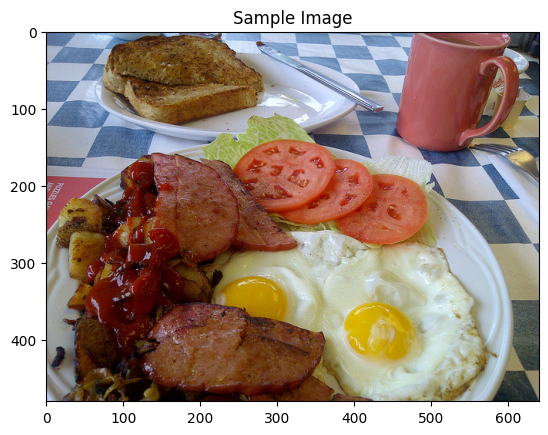

[0, 3, 60, 6, 20, 26, 13, 3, 112, 21, 3, 522, 18, 1]
a black and white photo of a table with a building .


In [12]:
get_prediction()

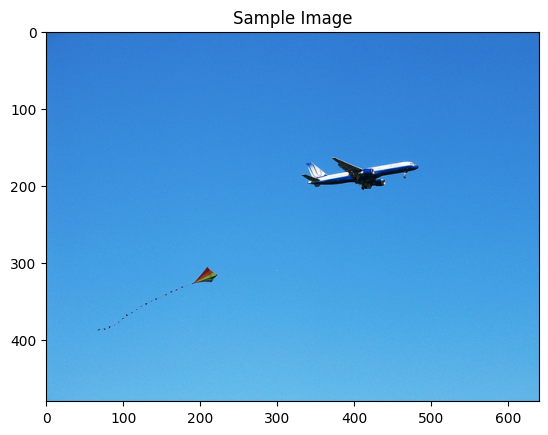

[0, 3, 1599, 507, 1157, 1076, 6, 3, 1660, 18, 1]
a plane wearing outdoor makeup and a floral .


In [16]:
get_prediction()

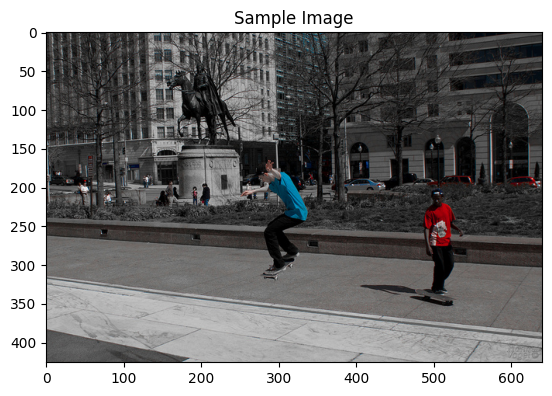

[0, 3, 3209, 903, 39, 16, 185, 13, 3, 271, 1]
a snowboarder truck on its side of a river


In [18]:
get_prediction()

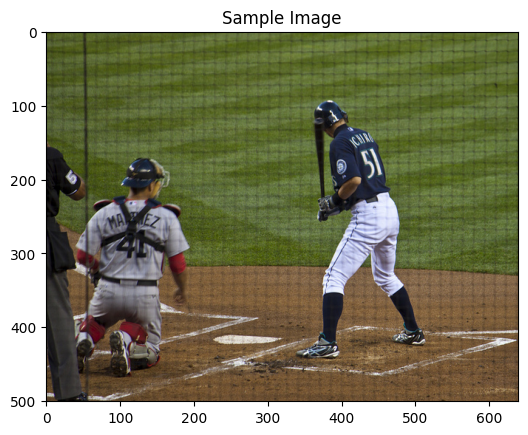

[0, 3, 169, 77, 3, 174, 77, 3, 60, 654, 1]
a man in a bus in a black remote


In [19]:
get_prediction()